In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import date
import datetime

In [2]:
original = pd.read_csv('data.csv')
data = original.copy()
data.columns = ['date', 'confirmed', 'recovered', 'deceased', 'other', 'tested', 'first', 'second', 'total']
data.drop(['deceased', 'other', 'recovered', 'second', 'total'], axis = 1, inplace = True)
data['date'] = pd.to_datetime(data['date'])
full_data = data[data.date >= '2021-03-08'].copy()
data = data[(data.date >= '2021-03-08') & (data.date <= '2021-04-26')].copy()
data = data.reset_index().drop('index', axis = 1)
data['confirmed'] = data['confirmed'].diff()
data['tested'] = data['tested'].diff()
# data['first'] = data['first'].diff()
data = data.drop(0, axis = 0).reset_index().drop('index', axis = 1)
data['confirmed'] = data['confirmed'].astype(int)
data['tested'] = data['tested'].astype(int)
data['first'] = data['first'].astype(int)

In [3]:
# defining some important dates
start = datetime.datetime(2021, 3, 16)
end = datetime.datetime(2021, 4, 26)
last_date = datetime.datetime(2021, 12, 31)

In [4]:
## creating timeseries (ground truth) for "confirmed cases average" till 26th April
timeseries = data.copy().to_numpy()
confirmed_avg = np.zeros(42)
for day in range(42):
    for prev_day in range(7):
        confirmed_avg[day] += timeseries[day + prev_day + 1][1] / 7 # averaging the "confirmed" column till 26th April

## creating timeseries (ground truth) for "tested average" till 31st December
tested = full_data[['date', 'tested']].copy().to_numpy()
for i in range(len(tested) - 1, 7, -1):
    tested[i][1] = (tested[i][1] - tested[i-7][1]) / 7
tested = tested[8:] # starting timeseries from 16th March 2021
# extrapolating the "tested" data till 31st Dec 2021
while (last_date - tested[-1][0]).days != 0:
    tested = np.append(tested, [[tested[-1][0] + datetime.timedelta(days = 1), tested[-1][1]]], axis = 0)

## creating timeseries (ground truth) for "first dose average"
first = data[['date', 'first']].copy().to_numpy()
for i in range(len(first) - 1, 6, -1):
    first[i][1] = (first[i][1] - first[i-7][1]) / 7
first = first[7:]
# extrapolating the "first dose" data till 31st Dec 2021
while (last_date - first[-1][0]).days != 0:
    first = np.append(first, [[first[-1][0] + datetime.timedelta(days = 1), 200000]], axis = 0)

## creating timeseries (ground truth) for "confirmed cases average" till 20th September (for Question 4)
ground_truth = full_data['confirmed'].copy().to_numpy()
for i in range(len(ground_truth) - 1, 7, -1):
    ground_truth[i] = (ground_truth[i] - ground_truth[i-7]) / 7
ground_truth = ground_truth[8:]

In [5]:
# def generateTimeSeries(S0, E0, I0, R0, V, tested, CIR0, BETA, ndays, N, ALPHA, GAMMA, EPS):
def generateTimeSeries(BETA, S0, E0, I0, R0, CIR0, V, tested, ndays, N, ALPHA, GAMMA, EPS, waning = True):
    S = np.zeros(ndays)
    E = np.zeros(ndays)
    I = np.zeros(ndays)
    R = np.zeros(ndays)
    e = np.zeros(ndays)

    S[0] = S0 
    E[0] = E0
    I[0] = I0 
    R[0] = R0

    # rewrite the time series function for longer "ndays"
    start_date = datetime.datetime(2021, 3, 16)
    end_date = datetime.datetime(2021, 4, 26)
    waning_date = datetime.datetime(2021, 9, 11)
    last_date = datetime.datetime(2021, 12, 31)

    for day in range(ndays - 1):
        if day <= 30:
            delW = R0 / 30
        elif day >= 180:
            if waning == True:
                delW = R[day - 180] + EPS * V[day - 180][1]
            else:
                delW = 0
            pass
        else:
            delW = 0
        S[day + 1] = S[day] - BETA * S[day] * I[day] / N - EPS * V[day][1] + delW
        E[day + 1] = E[day] + BETA * S[day] * I[day] / N - ALPHA * E[day]
        I[day + 1] = I[day] + ALPHA * E[day] - GAMMA * I[day]
        R[day + 1] = R[day] + GAMMA * I[day] + EPS * V[day][1] - delW

    avgS = np.zeros(ndays)
    avgE = np.zeros(ndays)
    avgI = np.zeros(ndays)
    avgR = np.zeros(ndays)

    for day in range(ndays):
        avg_count = 0
        for prev_day in range(day, day - 7, -1):
            if prev_day >= 0:
                avgS[day] += S[prev_day]
                avgE[day] += E[prev_day]
                avgI[day] += I[prev_day]
                avgR[day] += R[prev_day]
                avg_count += 1
        avgS[day] = avgS[day] / avg_count
        avgE[day] = avgE[day] / avg_count
        avgI[day] = avgI[day] / avg_count
        avgR[day] = avgR[day] / avg_count

    for day in range(ndays):
        CIR = CIR0 * tested[0][1] / tested[day][1] 
        e[day] = avgE[day] / CIR 

    return avgS, avgE, avgI, avgR, e 

In [6]:
def computeLoss(BETA, S0, E0, I0, R0, CIR0):
    # BETA, S0, E0, I0, R0, CIR0 = params[0], params[1], params[2], params[3], params[4], params[5]
    _, _, _, _, e = generateTimeSeries(BETA, S0, E0, I0, R0, CIR0, first, tested, 42, 70000000, 1 / 5.8, 1 / 5, 0.66)
    ALPHA = 1 / 5.8 

    e = ALPHA * e 
    e_avg = np.zeros(42)
    for i in range(42):
        count = 0
        for j in range(i, i - 7, -1):
            if j >= 0:
                count += 1
                e_avg[i] += e[j]
            else:
                break 
        e_avg[i] /= count 
    
    loss = 0
    for i in range(42):
        loss += (math.log(confirmed_avg[i]) - math.log(e_avg[i])) ** 2 
    loss /= 42
    return loss 

In [7]:
def computeGradient(params):

    BETA, S0, E0, I0, R0, CIR0 = params[0], params[1], params[2], params[3], params[4], params[5]

    f = computeLoss(BETA, S0, E0, I0, R0, CIR0)
    f_BETA = computeLoss(BETA + 0.01, S0, E0, I0, R0, CIR0)
    f_S0 = computeLoss(BETA, S0 + 1, E0, I0, R0, CIR0)
    f_E0 = computeLoss(BETA, S0, E0 + 1, I0, R0, CIR0)
    f_I0 = computeLoss(BETA, S0, E0, I0 + 1, R0, CIR0)
    f_R0 = computeLoss(BETA, S0, E0, I0, R0 + 1, CIR0)
    f_CIR0 = computeLoss(BETA, S0, E0, I0, R0, CIR0 + 0.1)

    grad_BETA = (f_BETA - f) / 0.01 
    grad_S0 = (f_S0 - f) 
    grad_E0 = (f_E0 - f)
    grad_I0 = (f_I0 - f)
    grad_R0 = (f_R0 - f)
    grad_CIR0 = (f_CIR0 - f) / 0.1
 
    grad = np.array([grad_BETA, grad_S0, grad_E0, grad_I0, grad_R0, grad_CIR0])

    return grad, f

In [13]:
def optimize_params(param, threshold = 10000):
    iterations = 0
    stepsize = 100

    while True:
        grad, loss = computeGradient(param)
        if iterations % 1000 == 0:
            print('iter: {}, loss: {}'.format(iterations, loss))
        iterations += 1

        if iterations == threshold or loss < 0.001:
            print('\nprogram terminating...')
            print('iter: {}, loss: {}'.format(iterations, loss))
            print('params: ', param)
            break 
        ## adjusting "stepsize" for faster convergence
        # if iterations < 500:
        #     stepsize = iterations 
        # else:
        #     stepsize = 500
        param = param - grad * (1 / (stepsize + 1))
        # param = param - grad * (1 / (iterations) + 1)
    return param 

In [18]:
param = np.array([4.49722551e-01, 4.89999999e+07, 7.69999180e+04, 7.69999182e+04, 2.08529999e+07, 1.28716990e+01])
# Comment-out below line to further optimize parameters using gradient descent
# param = optimize_params(param) 
print('loss for 2nd Question = ', computeLoss(param[0], param[1], param[2], param[3], param[4], param[5]))

loss for 2nd Question =  0.0029778394997330934


In [26]:
def plotSEIRWithoutImmunityWaning(param, ndays = 180):
    S, E, I, R, e = generateTimeSeries(param[0], param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, False)
    plt.plot(S, label = 'S')
    plt.plot(E, label = 'E')
    plt.plot(I, label = 'I')
    plt.plot(R, label = 'R')
    plt.legend()
    plt.title('Without immunity waning after 180 days')
    plt.xlabel('Days since 16 Mar 2021')
    plt.ylabel('Number of people')
    # plt.show()
    plt.savefig('SEIR-Without-Immunity-Waning.jpg')

In [32]:
def plotSEIRWithImmunityWaning(param, ndays = 180):
    S, E, I, R, e = generateTimeSeries(param[0], param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, True)
    plt.plot(S, label = 'S')
    plt.plot(E, label = 'E')
    plt.plot(I, label = 'I')
    plt.plot(R, label = 'R')
    plt.legend()
    plt.title('With immunity waning after 180 days')
    plt.xlabel('Days since 16 Mar 2021')
    plt.ylabel('Number of people')
    # plt.show()
    plt.savefig('SEIR-With-Immunity-Waning.jpg')

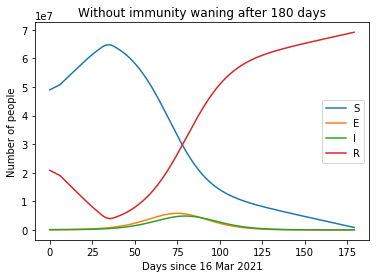

In [35]:
plotSEIRWithoutImmunityWaning(param)

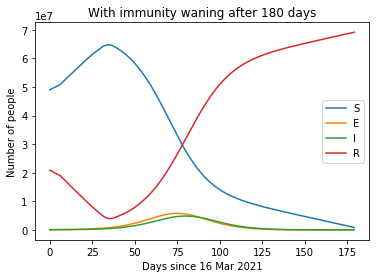

In [34]:
plotSEIRWithImmunityWaning(param)

In [36]:
def futureTimeSeries(B, S0, E0, I0, R0, CIR0, V, tested, ndays, N, ALPHA, GAMMA, EPS, waning = True, closed_loop = False):
    # 16th Mar 2021 is Tuesday, so compute average new cases every week and adjust BETA 
    S = np.zeros(ndays)
    E = np.zeros(ndays)
    I = np.zeros(ndays)
    R = np.zeros(ndays)
    e = np.zeros(ndays)

    S[0] = S0 
    E[0] = E0
    I[0] = I0 
    R[0] = R0
    BETA = B

    new_cases_each_day = []

    for day in range(ndays - 1):

        if closed_loop == True:
            # adjust BETA at the end of each week 
            if day % 7 == 1 and day >= 7:
                avg_cases_last_week = 0
                for i in range(7):
                    CIR = CIR0 * tested[0][1] / tested[day - i][1] 
                    avg_cases_last_week += ALPHA * (E[day - i]) / CIR 
                avg_cases_last_week /= 7
                # adjust BETA
                if avg_cases_last_week < 10000:
                    BETA = B 
                elif avg_cases_last_week < 25000:
                    BETA = B * 2 / 3
                elif avg_cases_last_week < 100000:
                    BETA = B / 2 
                else:
                    BETA = B / 3

        # immunity waning
        if day <= 30:
            delW = R0 / 30
        elif day >= 180:
            if waning == True:
                delW = R[day - 180] + EPS * V[day - 180][1]
            else:
                delW = 0
            pass
        else:
            delW = 0

        # predicting using the SEIR model
        S[day + 1] = S[day] - BETA * S[day] * I[day] / N - EPS * V[day][1] + delW
        E[day + 1] = E[day] + BETA * S[day] * I[day] / N - ALPHA * E[day]
        I[day + 1] = I[day] + ALPHA * E[day] - GAMMA * I[day]
        R[day + 1] = R[day] + GAMMA * I[day] + EPS * V[day][1] - delW

        CIR = CIR0 * tested[0][1] / tested[day][1] 
        new_cases_each_day.append(ALPHA * E[day])
    
    # computing average numbers for predicted SEIR values 
    avgS = np.zeros(ndays)
    avgE = np.zeros(ndays)
    avgI = np.zeros(ndays)
    avgR = np.zeros(ndays)

    for day in range(ndays):
        avg_count = 0
        for prev_day in range(day, day - 7, -1):
            if prev_day >= 0:
                avgS[day] += S[prev_day]
                avgE[day] += E[prev_day]
                avgI[day] += I[prev_day]
                avgR[day] += R[prev_day]
                avg_count += 1
        avgS[day] = avgS[day] / avg_count
        avgE[day] = avgE[day] / avg_count
        avgI[day] = avgI[day] / avg_count
        avgR[day] = avgR[day] / avg_count

    for day in range(ndays):
        CIR = CIR0 * tested[0][1] / tested[day][1] 
        e[day] = avgE[day] / CIR 

    return avgS, avgE, avgI, avgR, e, new_cases_each_day

In [37]:
# ndays = 188 for 20th September and ndays = 290 for 31st December predictions
def plotNewCasesEachDayOpenAndClosedLoop(param, ndays = 188):
    BETA = param[0]
    ndays = 188 # ndays = 188 for 20th September and ndays = 290 for 31st December predictions
    plt.figure(figsize = (9, 7))

    _, _, _, _, _, new_cases_each_day = futureTimeSeries(BETA, param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, True, closed_loop=False)
    plt.plot(new_cases_each_day, label = 'BETA, Open Loop')

    _, _, _, _, _, new_cases_each_day = futureTimeSeries(BETA * 2 / 3, param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, True, closed_loop=False)
    plt.plot(new_cases_each_day, label = '2/3 BETA, Open Loop')

    _, _, _, _, _, new_cases_each_day = futureTimeSeries(BETA / 2, param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, True, closed_loop=False)
    plt.plot(new_cases_each_day, label = '1/2 BETA, Open Loop')

    _, _, _, _, _, new_cases_each_day = futureTimeSeries(BETA / 3, param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, True, closed_loop=False)
    plt.plot(new_cases_each_day, label = '1/3 BETA, Open Loop')

    _, _, _, _, _, new_cases_each_day = futureTimeSeries(BETA, param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, True, closed_loop=True)
    plt.plot(new_cases_each_day, label = 'Closed Loop')

    plt.plot(ground_truth, label = 'Ground Truth (Reported Cases Only)')

    plt.legend()
    plt.title('Open-Loop & Closed-Loop Predictions till 20th Sep 2021')
    plt.xlabel('Days since 16 Mar 2021')
    plt.ylabel('Number of new cases each day')
    # plt.show()
    plt.savefig('NewCasesEachDayOpenAndClosedLoop.jpg')

In [ ]:
def plotSusceptibleOpenAndClosedLoop(param, ndays = 188):
    BETA = param[0]
    ndays = 188 # ndays = 188 for 20th September and ndays = 290 for 31st December predictions
    plt.figure(figsize = (9, 7))

    S, _, _, _, _, _ = futureTimeSeries(BETA, param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, True, closed_loop=False)
    plt.plot(S, label = 'BETA, Open Loop')

    S, _, _, _, _, _ = futureTimeSeries(BETA * 2 / 3, param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, True, closed_loop=False)
    plt.plot(S, label = '2/3 BETA, Open Loop')

    S, _, _, _, _, _ = futureTimeSeries(BETA / 2, param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, True, closed_loop=False)
    plt.plot(S, label = '1/2 BETA, Open Loop')

    S, _, _, _, _, _ = futureTimeSeries(BETA / 3, param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, True, closed_loop=False)
    plt.plot(S, label = '1/3 BETA, Open Loop')

    S, _, _, _, _, _ = futureTimeSeries(BETA, param[1], param[2], param[3], param[4], param[5], first, tested, ndays, 70000000, 1/5.8, 1/5, 0.66, True, closed_loop=True)
    plt.plot(S, label = 'Closed Loop')

    plt.legend()
    plt.title('Open-Loop & Closed-Loop Predictions till 20th Sep 2021')
    plt.xlabel('Days since 16 Mar 2021')
    plt.ylabel('Number of susceptible people')
    plt.show()

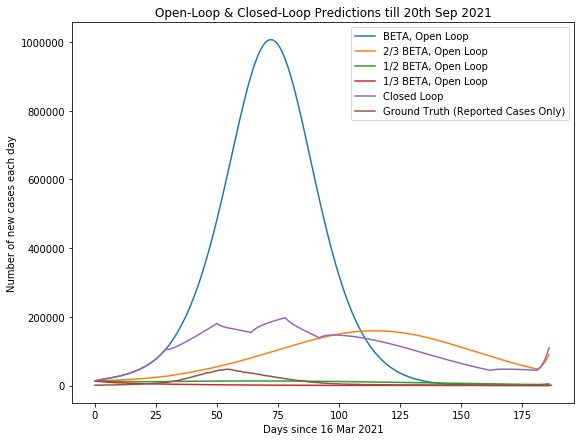

In [38]:
plotNewCasesEachDayOpenAndClosedLoop(param)